# Run for a normal segment - epileptic comparison
* 3 second segment
* patient 24
* recording 01

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sampling frequency: 256.0 Hz
Shape of loaded data: (22, 921600)
Expected shape from metadata: (22, 921600)
Loaded channel FP1-F7 with 921600 samples
Loaded channel data with shape: (921600,)
Loaded times with shape: (921600,)
Loaded metadata with keys: dict_keys(['channels', 'sfreq', 'times'])


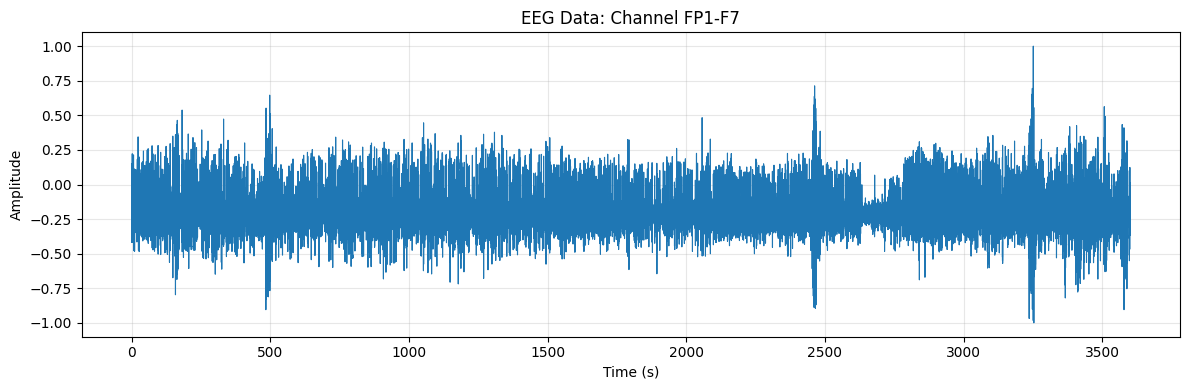

Channels plot 1-sec


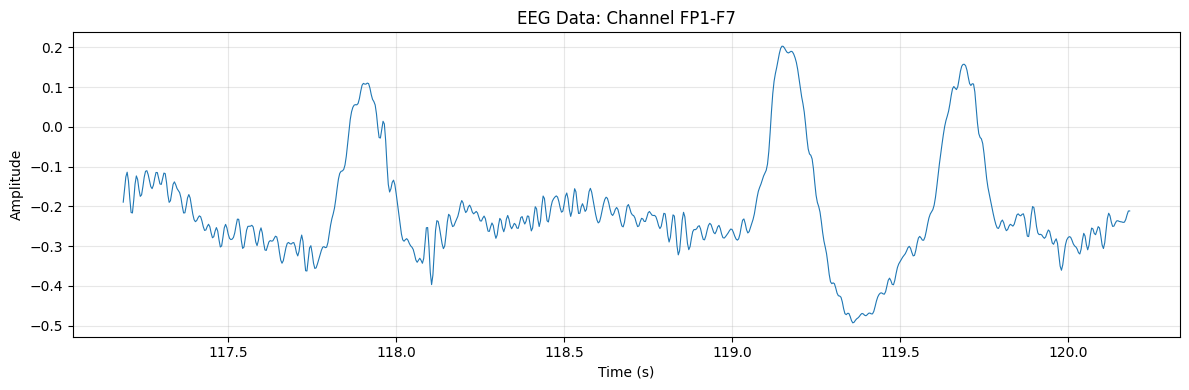

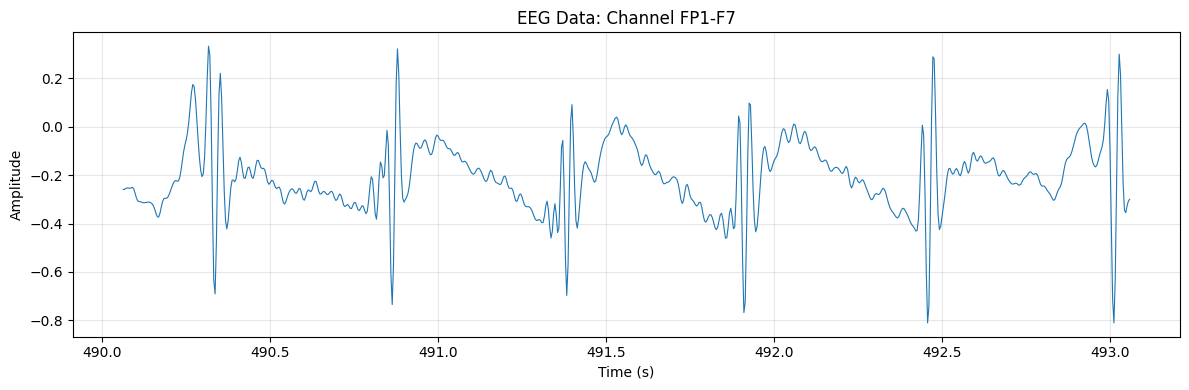

AMI process


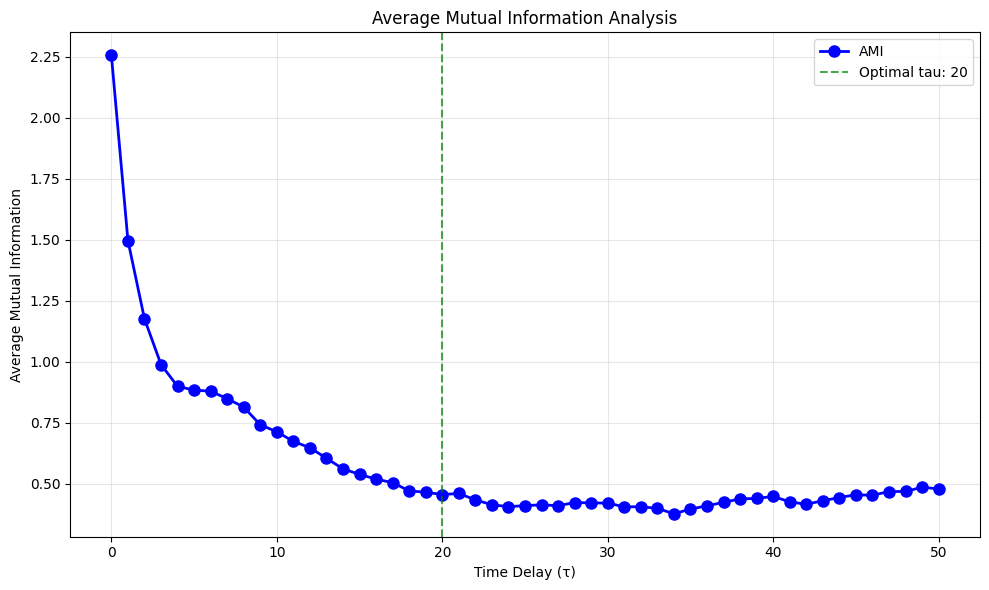

FNN process
Optimal embedding dimension: 5
FNN ratios: [0.94635488 0.26080893 0.05571429 0.02346041 0.00753012 0.00309119
 0.00159236 0.00164474 0.         0.         0.         0.
 0.         0.         0.        ]


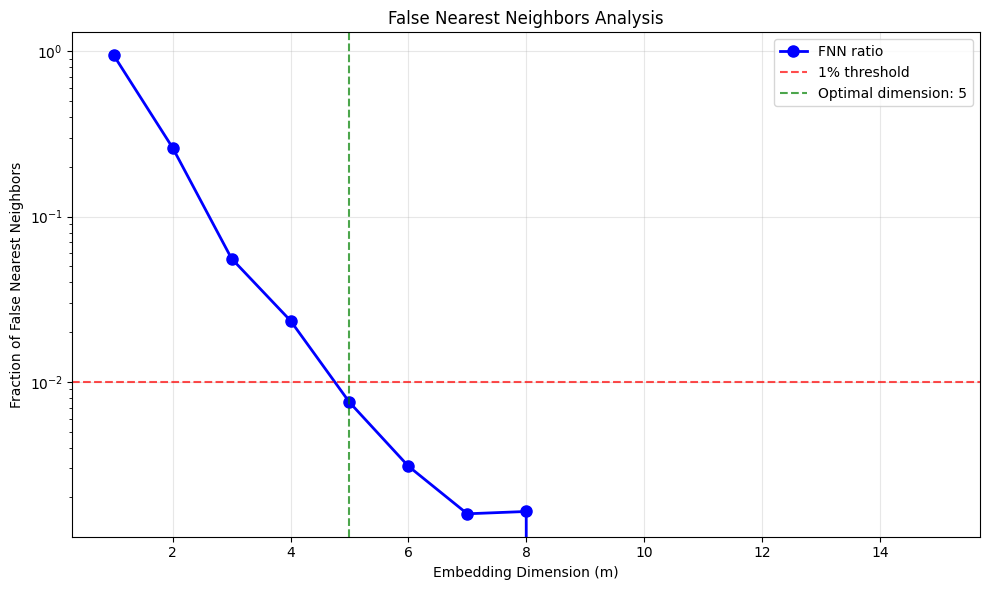

-----  DETERMINED -----
Optimal DIMESION: 5
Optimal TAU: 20
creating {n_vectors} vectors
Created 688 phase space vectors with m=5 and tau=20
creating {n_vectors} vectors
Created 688 phase space vectors with m=5 and tau=20
-----  VISUALIZE -----
PSR comparison using optimal obtained values


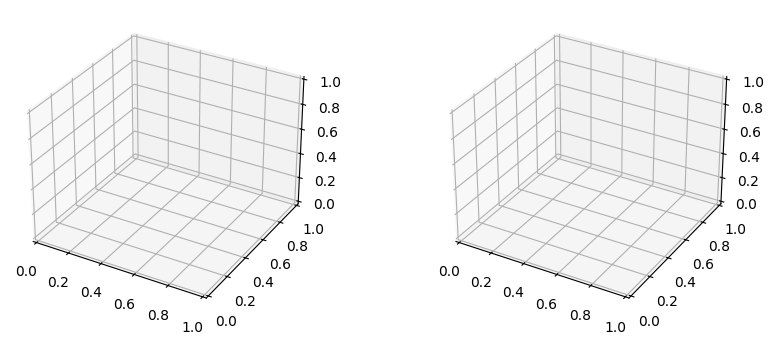

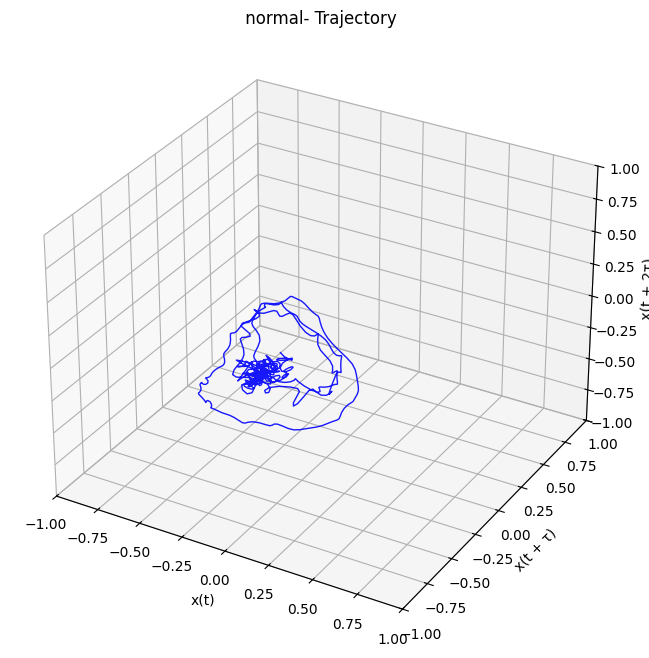

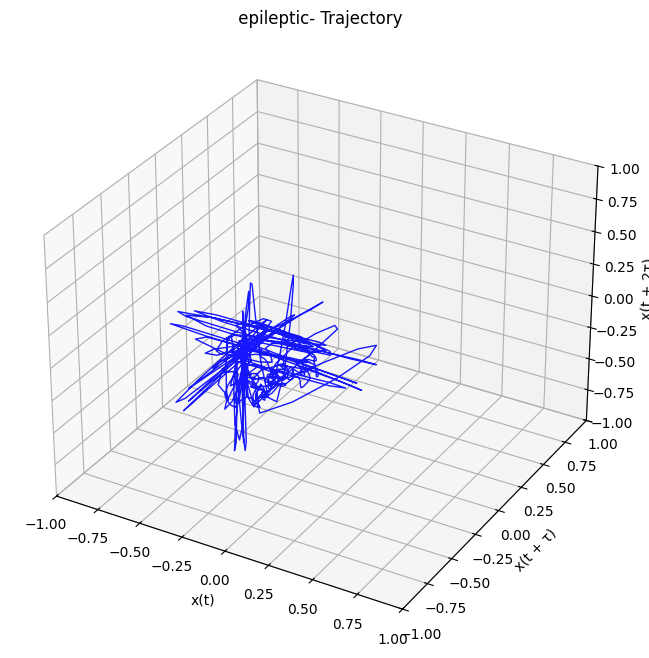

<Figure size 640x480 with 0 Axes>

Calculating RQA metrics...
Parameters:
m: 5
tau: 20
Calculating RQA metrics for normal segment
creating {n_vectors} vectors
Created 688 phase space vectors with m=5 and tau=20
RQA Metrics:
recurrence_rate: 0.0092
determinism: 0.7346
average_diagonal_line: 3.9950
longest_diagonal_line: 115.0000
divergence: 0.0087
entropy_diagonal_lines: 1.2828
laminarity: 0.6912
trapping_time: 2.6714
longest_vertical_line: 11.0000
number_diagonal_lines: 798.0000
number_vertical_lines: 1123.0000
ratio_determ_recurrence: 80.1153


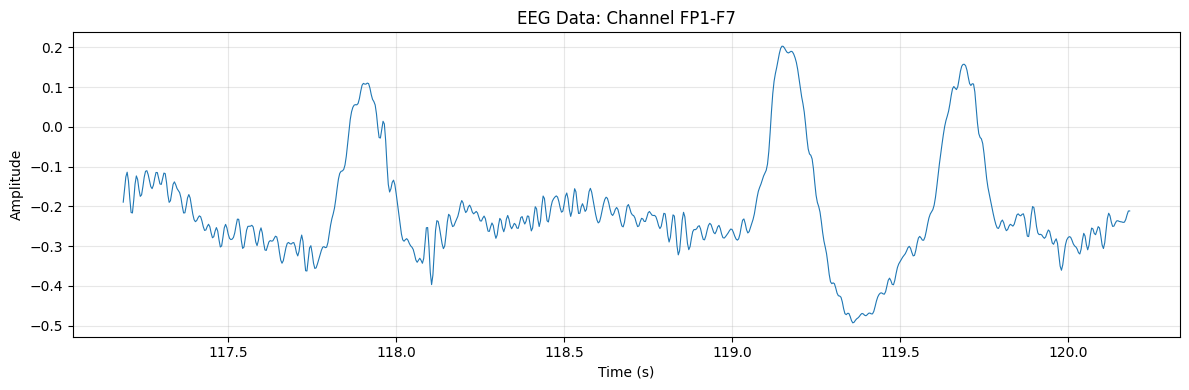

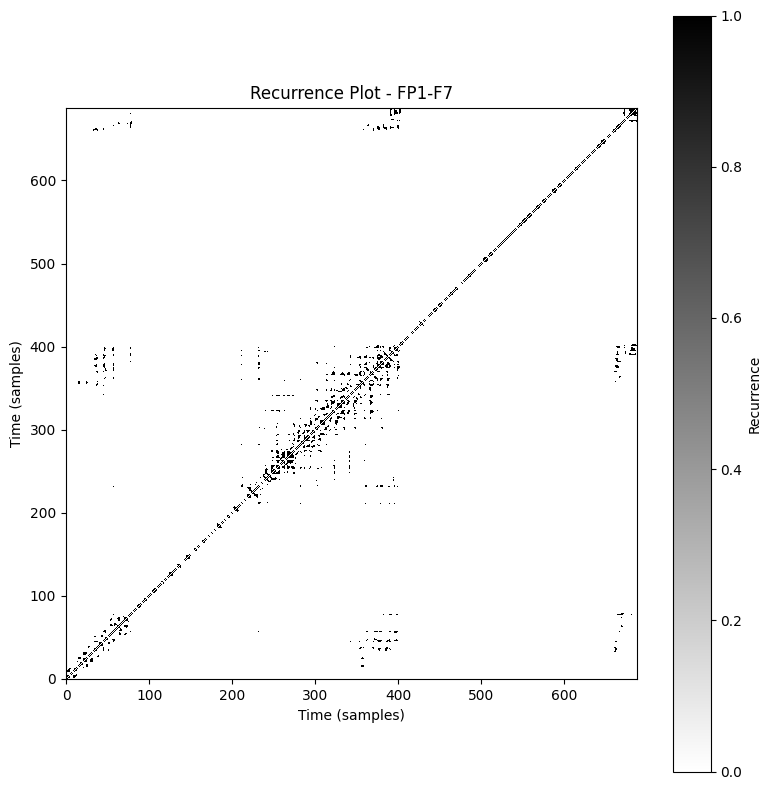

Calculating RQA metrics for epileptic segment...
creating {n_vectors} vectors
Created 688 phase space vectors with m=5 and tau=20
RQA Metrics:
recurrence_rate: 0.0020
determinism: 0.6617
average_diagonal_line: 4.5362
longest_diagonal_line: 38.0000
divergence: 0.0263
entropy_diagonal_lines: 1.3862
laminarity: 0.5211
trapping_time: 2.5282
longest_vertical_line: 9.0000
number_diagonal_lines: 138.0000
number_vertical_lines: 195.0000
ratio_determ_recurrence: 331.1074


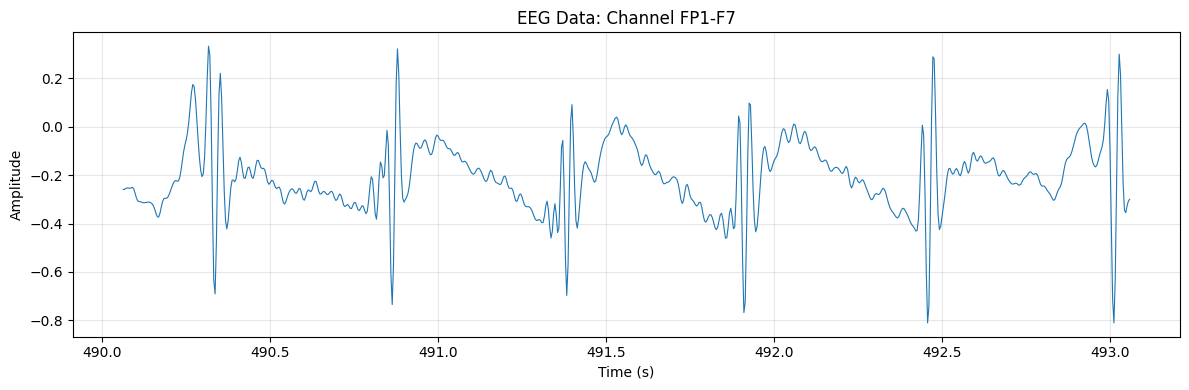

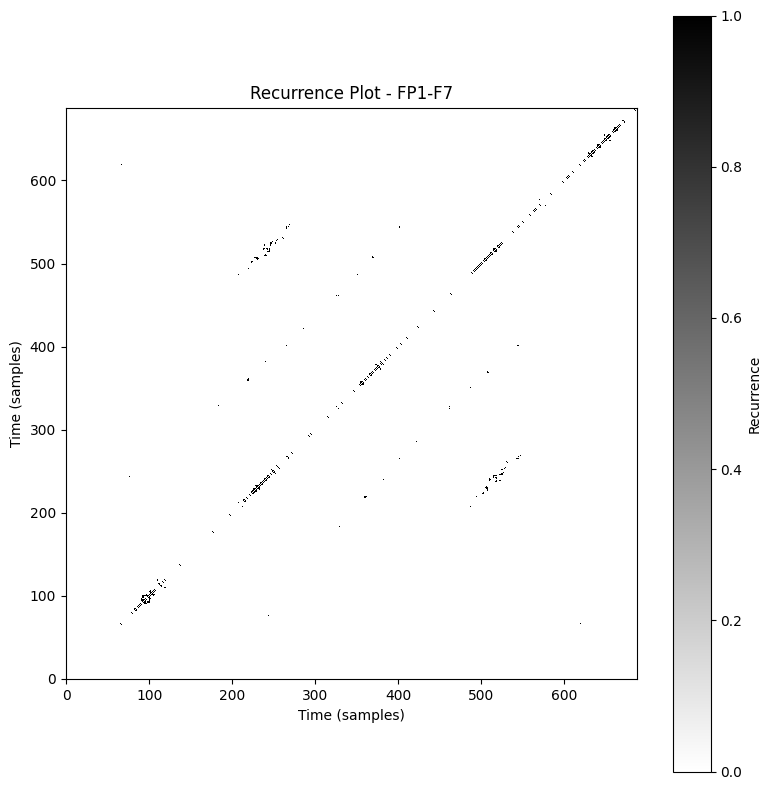

/tmp/ipython-input-3262656330.py:639: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(Pxx, f)
/tmp/ipython-input-3262656330.py:641: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(Pxx[band_idx], f[band_idx]) if np.any(band_idx) else 0.0


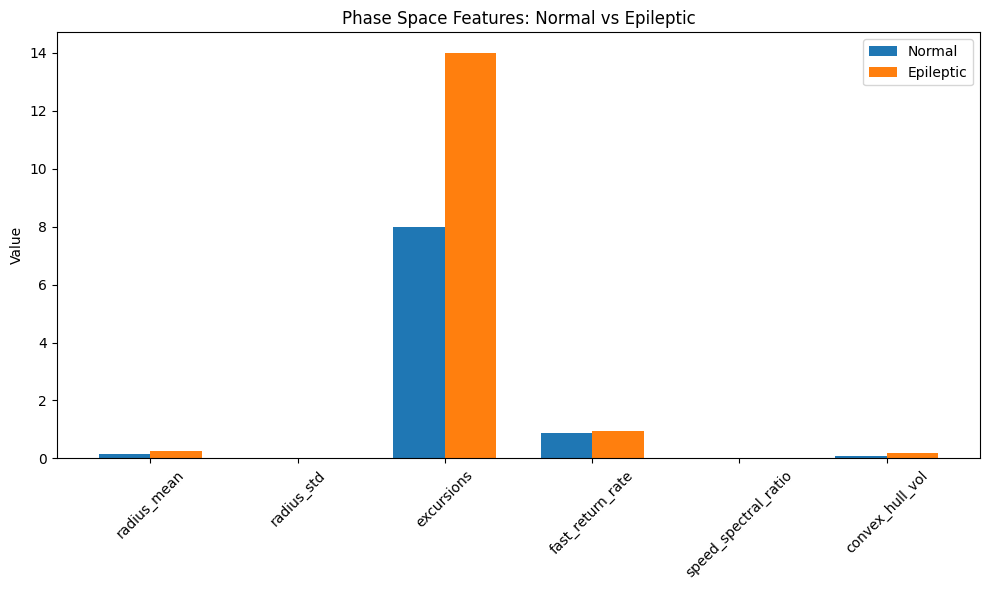

'\n    ### per frequency band processing.\n    # Process each frequency band\n    for band_name, (low_freq, high_freq) in FREQUENCY_BANDS.items():\n        print(f"\nProcessing {band_name} band ({low_freq}-{high_freq} Hz)")\n\n        # Filter the segment data for the current band\n        filtered_segment = filter_signal(segment_data, sfreq, low_freq, high_freq)\n\n        # Plot the filtered signal\n        plot_single_channel(filtered_segment, segment_time, f"{selected_channel} ({band_name} band)")\n\n        # Create phase space vectors\n        psv = create_phase_space_vectors(filtered_segment, m=optimal_dim, tau=optimal_tau)\n\n        # Visualize 3D phase space (using first 3 dimensions)\n        try:\n            visualize_phase_space(psv[:, :3])\n        except ValueError as e:\n            print(f"Skipping phase space visualization for {band_name} band: {e}")\n\n        # Calculate RQA metrics\n        metrics, recurrence_matrix = calculate_rqa_metrics_custom(filtered_segment

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from google.colab import drive, files
from scipy import signal  # Added for filtering


from scipy.signal import welch
from scipy.spatial import ConvexHull
from numpy.linalg import norm
# testing on one channel

selected_channel = 'P8-O2'
selected_channel = 'FT10-T8'

selected_channel = 'FP1-F7'

# Mount Google Drive
drive.mount('/content/drive')


# Define frequency bands
FREQUENCY_BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    #'alpha': (8, 13),
    #'beta': (13, 30),
    #'gamma': (30, 100)
}

def filter_signal(data, sfreq, low_freq, high_freq, order=4):
    """
    Apply a bandpass filter to isolate a specific frequency band.

    Parameters:
    data: 1D numpy array (time series)
    sfreq: Sampling frequency (Hz)
    low_freq: Lower frequency bound (Hz)
    high_freq: Upper frequency bound (Hz)
    order: Butterworth filter order

    Returns:
    filtered_data: Filtered time series
    """
    nyquist = sfreq / 2.0
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data


def find_optimal_tau_ami(time_series, max_tau=50, bins=16, smooth_window=None):
    """
    Compute AMI (via average_mutual_information) and return the first local minimum
    (τ >= 1). If no local minimum is found, fall back to the 1/e rule.

    Returns: optimal_tau (int), ami_curve (np.array indexed by τ=0..max_tau)
    """
    ami_curve = average_mutual_information(time_series, max_tau=max_tau, bins=bins)

    # optional smoothing (helps with noisy AMI curves)
    if smooth_window and smooth_window > 1:
        from scipy.ndimage import uniform_filter1d
        ami_curve = uniform_filter1d(ami_curve, size=smooth_window, mode='nearest')

    # robust local-minimum detection (search τ = 1 .. max_tau-1)
    if len(ami_curve) >= 3:
        # check interior points: ami[1]..ami[-2] compared with neighbors
        interior = ami_curve[1:-1]
        left   = ami_curve[:-2]
        right  = ami_curve[2:]
        local_min_mask = (interior < left) & (interior < right)
        local_mins = np.where(local_min_mask)[0]
        if local_mins.size > 0:
            # local_mins[0] corresponds to ami index = (local_mins[0] + 1)
            optimal_tau = int(local_mins[0] + 1)
            return optimal_tau, ami_curve

    # fallback: 1/e rule (first τ where AMI < initial/ e)
    initial_ami = ami_curve[0]
    threshold = initial_ami * (1.0 / np.e)
    candidate_taus = np.where(ami_curve < threshold)[0]
    optimal_tau = int(candidate_taus[0]) if candidate_taus.size > 0 else 1

    return optimal_tau, ami_curve

def average_mutual_information(x, max_tau=50, bins=16):
    """
    Compute Average Mutual Information (AMI) for delays 0...max_tau.

    Parameters:
    x : 1D numpy array (time series)
    max_tau : maximum time delay
    bins : number of bins for histogram

    Returns:
    ami : numpy array of AMI values
    """
    # Digitize signal into bins
    hist, bin_edges = np.histogram(x, bins=bins)
    digitized = np.digitize(x, bin_edges[:-1])

    ami = []
    for tau in range(max_tau+1):
        if tau == 0:
            # AMI at lag 0 is entropy of distribution
            mi = mutual_info_score(digitized, digitized)
        else:
            mi = mutual_info_score(digitized[:-tau], digitized[tau:])
        ami.append(mi)
    return np.array(ami)

def find_optimal_dimension(fnn_ratio, threshold=0.02, stability_window=2):
    """
    Find optimal embedding dimension using the Kennel et al. criterion.
    Returns the first dimension where FNN drops below threshold and stays stable.

    Parameters:
    fnn_ratio: array of FNN percentages for each dimension
    threshold: maximum acceptable FNN percentage (typically 1-5%)
    stability_window: number of consecutive dimensions that must stay low

    Returns:
    optimal_dim: optimal embedding dimension
    """
    # Look for the first dimension where FNN drops below threshold
    # and remains consistently low for the next few dimensions
    for d in range(len(fnn_ratio) - stability_window):
        current_window = fnn_ratio[d:d+stability_window]

        # Check if all values in the window are below threshold
        # and that they don't show an increasing trend (noise amplification)
        if (np.all(current_window <= threshold) and
            not np.any(np.diff(current_window) > 0.005)):  # avoid increasing trend
            return d + 1  # +1 because dimensions start at 1

    # Fallback: return dimension with minimum FNN that's below reasonable threshold
    candidate_dims = np.where(fnn_ratio <= 0.05)[0]  # dimensions with FNN ≤ 5%
    if len(candidate_dims) > 0:
        return candidate_dims[0] + 1

    # Final fallback: dimension with absolute minimum FNN
    return np.argmin(fnn_ratio) + 1

def false_nearest_neighbors(time_series, tau=1, max_dim=10, rtol=15.0, atol=2.0):
    """
    implementινγ the False Nearest Neighbors algorithm based on:
    Kennel, M. B., Brown, R., & Abarbanel, H. D. I. (1992).
    Determining embedding dimension for phase-space reconstruction using a geometrical construction.
    Physical Review A, 45(6), 3403.

    Parameters:
    time_series: 1D array of scalar measurements
    tau: time delay
    max_dim: maximum embedding dimension to test
    rtol: tolerance for relative distance criterion
    atol: tolerance for absolute distance criterion

    Returns:
    fnn_ratio: array of false nearest neighbor ratios for each dimension
    optimal_dim: optimal embedding dimension
    """
    n = len(time_series)
    fnn_ratio = np.zeros(max_dim)
    R_d = np.std(time_series)  # attractor size estimate

    # For each dimension from 1 to max_dim
    for d in range(1, max_dim + 1):
        # Build phase-space vectors in dimension d
        n_vectors = n - (d-1)*tau
        if n_vectors <= 0:
            fnn_ratio[d-1] = 1.0
            continue

        phase_space_d = np.zeros((n_vectors, d))
        for i in range(n_vectors):
            for j in range(d):
                phase_space_d[i, j] = time_series[i + j*tau]

        # Find nearest neighbors in d dimensions using KDTree for efficiency
        tree = KDTree(phase_space_d)
        dists_d, indices_d = tree.query(phase_space_d, k=2)  # k=2 to exclude self
        nearest_dists = dists_d[:, 1]  # distances to nearest neighbor
        nearest_indices = indices_d[:, 1]  # indices of nearest neighbors

        false_count = 0
        valid_pairs = 0

        # Check each point for false neighbors when moving to dimension d+1
        for i in range(n_vectors):
            j = nearest_indices[i]  # index of nearest neighbor in d-dim

            # Skip if we can't compute the (d+1)th coordinate
            if (i + d*tau >= n) or (j + d*tau >= n):
                continue

            dist_d = nearest_dists[i]

            # Get the next coordinate in dimension d+1 (Eq. 3 in paper)
            x_i_next = time_series[i + d*tau]
            x_j_next = time_series[j + d*tau]
            new_coord_diff = x_i_next - x_j_next

            # Compute new distance in d+1 using Pythagorean theorem
            dist_d_plus_1 = np.sqrt(dist_d**2 + new_coord_diff**2)

            # Apply both criteria (Eq. 4 and 5 in paper)
            if dist_d > 1e-10:  # avoid division by zero
                # Criterion 1: Relative distance increase
                criterion1 = (abs(new_coord_diff) / dist_d) > rtol

                # Criterion 2: Absolute distance relative to attractor size
                criterion2 = (dist_d_plus_1 / R_d) > atol

                if criterion1 or criterion2:
                    false_count += 1

                valid_pairs += 1

        fnn_ratio[d-1] = false_count / valid_pairs if valid_pairs > 0 else 0


    optimal_dim = find_optimal_dimension(fnn_ratio, threshold=0.02, stability_window=2)

    return fnn_ratio, optimal_dim

def plot_fnn_results(fnn_ratio, optimal_dim):
    """Plot FNN analysis results with proper formatting"""
    dimensions = range(1, len(fnn_ratio) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(dimensions, fnn_ratio, 'bo-', linewidth=2, markersize=8, label='FNN ratio')
    plt.axhline(y=0.01, color='r', linestyle='--', alpha=0.7, label='1% threshold')
    plt.axvline(x=optimal_dim, color='g', linestyle='--', alpha=0.7,
                label=f'Optimal dimension: {optimal_dim}')

    plt.xlabel('Embedding Dimension (m)')
    plt.ylabel('Fraction of False Nearest Neighbors')
    plt.title('False Nearest Neighbors Analysis')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

def load_single_channel(npy_path, metadata_path, channel_name):
    """Load a single EEG channel into a NumPy array."""
    # Load data and metadata
    data = np.load(npy_path)
    metadata = np.load(metadata_path, allow_pickle=True).item()
    channels = metadata['channels']  # List of channel names
    times = metadata['times']

    # Print shapes for debugging
    print(f"Shape of loaded data: {data.shape}")
    print(f"Expected shape from metadata: ({len(channels)}, {len(times)})")


    # Find index of the selected channel
    try:
        channel_idx = channels.index(channel_name)
    except ValueError:
        raise ValueError(f"Channel {channel_name} not found in {channels}")

    # Extract the single channel data
    single_channel_data = data[channel_idx]

    print(f"Loaded channel {channel_name} with {len(single_channel_data)} samples")

    return single_channel_data, times

def plot_single_channel(data, times, channel_name):
    """Plot the single channel data."""
    plt.figure(figsize=(12, 4))
    plt.plot(times, data, linewidth=0.8)
    plt.title(f"EEG Data: Channel {channel_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_phase_space_vectors(segment_data, m=3, tau=1):
    # Check if segment_data is long enough for embedding
    n_samples = len(segment_data)
    if n_samples < m * tau:
        raise ValueError(f"Segment length ({n_samples}) is too short for m={m} and tau={tau}")

    # Calculate the number of phase space vectors
    n_vectors = n_samples - (m - 1) * tau
    print("creating {n_vectors} vectors")

    # Initialize array to store phase space vectors
    phase_space_vectors = np.zeros((n_vectors, m))

    # Construct phase space vectors using a for loop
    for i in range(n_vectors):
        for j in range(m):
            phase_space_vectors[i, j] = segment_data[i + j * tau]

    print(f"Created {n_vectors} phase space vectors with m={m} and tau={tau}")

    return phase_space_vectors

def visualize_phase_space(phase_space_vectors, title):

    if phase_space_vectors.shape[1] != 3:
        raise ValueError("Phase space vectors must have 3 dimensions for 3D visualization")

    # Create 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Extract x, y, z coordinates
    x = phase_space_vectors[:, 0]
    y = phase_space_vectors[:, 1]
    z = phase_space_vectors[:, 2]

    # Plot the trajectory with connected lines in black
    ax.plot(x, y, z, linewidth=1, alpha=0.9, color='blue')

    # Set labels
    ax.set_xlabel('x(t)')
    ax.set_ylabel('x(t + τ)')
    ax.set_zlabel('x(t + 2τ)')
    ax.set_title(f' {title}- Trajectory')

    # Set equal axis scaling
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+y.min()) * 0.5
    mid_z = (z.max()+z.min()) * 0.5
    ax.set_xlim(-1,1)
    #ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(-1,1)
    #ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(-1,1)
    #ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()



def create_recurrence_matrix(phase_space_vectors, radius=0.2):
    """
            Parameters:
    phase_space_vectors: N x m array of phase space vectors
    radius: recurrence threshold
            Returns:
    recurrence_matrix: N x N binary matrix
    """
    # Calculate pairwise distances
    distances = squareform(pdist(phase_space_vectors, 'euclidean'))

    # Create recurrence matrix (1 if distance <= radius, 0 otherwise)
    recurrence_matrix = (distances <= radius).astype(int)

    # Remove self-recurrences (main diagonal)
    np.fill_diagonal(recurrence_matrix, 0)

    return recurrence_matrix

def calculate_diagonal_lines(recurrence_matrix, min_line_length=2):
    n = recurrence_matrix.shape[0]
    diagonal_lengths = []

    # Check all diagonals (offset from main diagonal)
    for k in range(-n + 1, n):
        diag = np.diag(recurrence_matrix, k)

        # Find sequences of 1s (recurrences)
        current_length = 0
        for value in diag:
            if value == 1:
                current_length += 1
            else:
                if current_length >= min_line_length:
                    diagonal_lengths.append(current_length)
                current_length = 0

        # Check if line continues to the end
        if current_length >= min_line_length:
            diagonal_lengths.append(current_length)

    return diagonal_lengths


def calculate_vertical_lines(recurrence_matrix, min_line_length=2):
    n = recurrence_matrix.shape[0]

    vertical_lengths = []

    for j in range(n):
        col = recurrence_matrix[:, j]

        current_length = 0
        for value in col:
            if value == 1:
                current_length += 1
            else:
                if current_length >= min_line_length:
                    vertical_lengths.append(current_length)
                current_length = 0

        if current_length >= min_line_length:
            vertical_lengths.append(current_length)

    return vertical_lengths

    #calculation of RQA features
def calculate_rqa_metrics_custom(segment_data, m=3, tau=1, radius=0.1):
    # Create phase space vectors
    phase_space_vectors = create_phase_space_vectors(segment_data, m, tau)

    # Create recurrence matrix
    R = create_recurrence_matrix(phase_space_vectors, radius)
    n = R.shape[0]
    total_points = n * n

    # Calculate basic statistics
    recurrence_rate = np.sum(R) / total_points

    # Diagonal line analysis
    diagonal_lengths = calculate_diagonal_lines(R)
    total_diagonal_lines = len(diagonal_lengths)
    sum_diagonal_lines = sum(diagonal_lengths)

    if total_diagonal_lines > 0:
        determinism = sum_diagonal_lines / np.sum(R)
        avg_diagonal_line = sum_diagonal_lines / total_diagonal_lines
        max_diagonal_line = max(diagonal_lengths) if diagonal_lengths else 0
        divergence = 1.0 / max_diagonal_line if max_diagonal_line > 0 else float('inf')

        # Entropy of diagonal line lengths
        unique, counts = np.unique(diagonal_lengths, return_counts=True)
        entropy_diagonal = entropy(counts / total_diagonal_lines)
    else:
        determinism = avg_diagonal_line = max_diagonal_line = entropy_diagonal = 0
        divergence = float('inf')

    # Vertical line analysis (laminarity)
    vertical_lengths = calculate_vertical_lines(R)
    total_vertical_lines = len(vertical_lengths)
    sum_vertical_lines = sum(vertical_lengths)

    if total_vertical_lines > 0:
        laminarity = sum_vertical_lines / np.sum(R)
        avg_vertical_line = sum_vertical_lines / total_vertical_lines
        max_vertical_line = max(vertical_lengths) if vertical_lengths else 0
        trapping_time = avg_vertical_line
    else:
        laminarity = avg_vertical_line = max_vertical_line = trapping_time = 0

    # Return all metrics
    metrics = {
        'recurrence_rate': recurrence_rate,
        'determinism': determinism,
        'average_diagonal_line': avg_diagonal_line,
        'longest_diagonal_line': max_diagonal_line,
        'divergence': divergence,
        'entropy_diagonal_lines': entropy_diagonal,
        'laminarity': laminarity,
        'trapping_time': trapping_time,
        'longest_vertical_line': max_vertical_line,
        'number_diagonal_lines': total_diagonal_lines,
        'number_vertical_lines': total_vertical_lines,
        'ratio_determ_recurrence': determinism / recurrence_rate if recurrence_rate > 0 else 0
    }

    return metrics, R


def plot_rp(recurrence_matrix, title="Recurrence Plot"):
    """
    Plot the custom recurrence matrix.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(recurrence_matrix, cmap='binary', origin='lower',
               aspect='equal', interpolation='none')
    plt.title(title)
    plt.xlabel('Time (samples)')
    plt.ylabel('Time (samples)')
    plt.colorbar(label='Recurrence')
    plt.tight_layout()
    plt.show()


def plot_ami_results(ami_curve, optimal_tau, max_tau):
    """Plot AMI analysis results with proper formatting"""
    taus = range(len(ami_curve))

    plt.figure(figsize=(10, 6))
    plt.plot(taus, ami_curve, 'bo-', linewidth=2, markersize=8, label='AMI')
    plt.axvline(x=optimal_tau, color='g', linestyle='--', alpha=0.7,
                label=f'Optimal tau: {optimal_tau}')

    plt.xlabel('Time Delay (τ)')
    plt.ylabel('Average Mutual Information')
    plt.title('Average Mutual Information Analysis')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def compare_phase_space(normal_psv, epileptic_psv):
    # Make subplot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})
    # Normal segment subplot
    #ax1 = fig.add_subplot(121, projection='3d')

    visualize_phase_space(normal_psv[:, :3],"normal")

    # Epileptic segment subplot
    #ax2 = fig.add_subplot(122, projection='3d')

    visualize_phase_space(epileptic_psv[:, :3], "epileptic")

    plt.tight_layout()
    plt.show()


############ custom features #####################
import numpy as np
from scipy.signal import welch
from scipy.spatial import ConvexHull
from numpy.linalg import norm

def phase_centroid(psv):
    return np.mean(psv, axis=0)

def radius_series(psv):
    c = phase_centroid(psv)
    r = np.linalg.norm(psv - c, axis=1)
    return r

def radius_features(psv, sfreq=None):
    """
    Returns variance, mean, and first-autocorr lag index of the radius series.
    """
    r = radius_series(psv)
    var = np.var(r)
    mean = np.mean(r)
    # normalized autocorrelation (lag 1..maxlag), find first positive peak if any
    rzero = r - r.mean()
    acf = np.correlate(rzero, rzero, mode='full')
    acf = acf[acf.size//2:]
    acf = acf / (acf[0] + 1e-12)
    # find lag of first local maximum after lag 0
    if len(acf) > 2:
        # simple peak detection
        peaks = np.where((acf[1:-1] > acf[:-2]) & (acf[1:-1] > acf[2:]))[0] + 1
        first_peak_lag = int(peaks[0]) if peaks.size>0 else None
    else:
        first_peak_lag = None
    return {'radius_var': var, 'radius_mean': mean, 'radius_first_peak_lag': first_peak_lag, 'radius_acf': acf}

def excursion_count(psv, thresh=None, method='pct', pct=75):
    """
    Count number of excursions (leave threshold and return).
    thresh: absolute radius threshold; if None, compute from percentile of radius.
    method: 'pct' uses percentile of radius values.
    """
    r = radius_series(psv)
    if thresh is None:
        thresh = np.percentile(r, pct)
    outside = r > thresh
    # count transitions 0->1 = leave, and 1->0 = return
    leaves = np.where((~outside[:-1]) & (outside[1:]))[0].size
    returns = np.where((outside[:-1]) & (~outside[1:]))[0].size
    # excursion count = min(leaves, returns) to count complete out-and-back
    excursions = min(leaves, returns)
    # average excursion duration in samples (time outside)
    durations = []
    in_idx = np.where(outside)[0]
    if in_idx.size:
        # find contiguous runs
        splits = np.where(np.diff(in_idx) != 1)[0]
        runs = np.split(in_idx, splits+1)
        for run in runs:
            durations.append(run.size)
    avg_dur = np.mean(durations) if durations else 0
    return {'thresh': thresh, 'excursions': excursions, 'avg_excursion_duration_samples': avg_dur, 'num_leaves': leaves, 'num_returns': returns}

def fast_return_rate(psv, thresh=None, max_return_samples=50, pct=75):
    """
    Fraction of excursions that return within max_return_samples (fast back-and-forth).
    """
    r = radius_series(psv)
    if thresh is None:
        thresh = np.percentile(r, pct)
    outside = r > thresh
    idx = np.arange(len(r))
    # find start indices of outside runs and their end indices
    runs = []
    i = 0
    N = len(r)
    while i < N:
        if outside[i]:
            j = i
            while j+1 < N and outside[j+1]:
                j += 1
            runs.append((i, j))
            i = j+1
        else:
            i += 1
    if not runs:
        return {'fast_return_rate': 0.0}
    fast = 0
    for (s, e) in runs:
        # check how many samples until it returns (next sample index after e is return index)
        # if returned within window max_return_samples, count as fast
        # find next index after e that is within threshold
        ret_idx = e + 1
        if ret_idx < N:
            # if within max_return_samples the outside->inside transition occurred quickly
            if ret_idx - s <= max_return_samples:
                fast += 1
    rate = fast / len(runs)
    return {'fast_return_rate': rate, 'n_runs': len(runs)}

def speed_spectral_ratio(psv, sfreq, nperseg=None, lowcut_hz=(0.5, 4.0)):
    """
    Compute instantaneous speed in phase space and return low-frequency power ratio.
    lowcut_hz: tuple (f_low, f_high) of band to treat as 'slow oscillation' (e.g., 0.5-4Hz).
    """
    # instantaneous speed
    diffs = np.diff(psv, axis=0)
    speeds = np.linalg.norm(diffs, axis=1)
    if nperseg is None:
        nperseg = min(256, max(8, len(speeds)//8))
    f, Pxx = welch(speeds, fs=sfreq, nperseg=nperseg)
    total_power = np.trapz(Pxx, f)
    band_idx = (f >= lowcut_hz[0]) & (f <= lowcut_hz[1])
    band_power = np.trapz(Pxx[band_idx], f[band_idx]) if np.any(band_idx) else 0.0
    ratio = band_power / (total_power + 1e-12)
    return {'speed_lowband_power_ratio': ratio, 'speeds': speeds, 'f': f, 'Pxx': Pxx}

def convex_hull_volume(psv):
    """
    Convex hull area (2D) or volume (m-D). For m>2, hull.volume is the m-D volume.
    Returns None if points degenerate or not enough points.
    """
    try:
        if psv.shape[0] <= psv.shape[1]:
            return {'hull_volume': 0.0}
        hull = ConvexHull(psv)
        return {'hull_volume': hull.volume}
    except Exception as e:
        return {'hull_volume': None, 'hull_error': str(e)}

def recurrence_flux_from_rp(RP, max_lag=None):
    """
    RP is a binary recurrence matrix (N x N).
    Compute sum of recurrence values in off-diagonal bands (lag > 0).
    Optionally compute lag profile (recurrence count per lag).
    """
    N = RP.shape[0]
    if max_lag is None:
        max_lag = N - 1
    lag_counts = np.zeros(max_lag+1)
    for lag in range(max_lag+1):
        diag = np.diag(RP, k=lag)
        lag_counts[lag] = np.sum(diag)
    # normalize by number of possible pairs per lag
    denom = np.array([N - l for l in range(max_lag+1)])
    lag_profile = lag_counts / (denom + 1e-12)
    # flux metrics: presence of peaks at intermediate lags suggests repeated return periods
    # compute a simple measure: std of lag_profile (higher if concentrated)
    return {'lag_profile': lag_profile, 'lag_std': np.std(lag_profile), 'lag_peak_lags': np.argsort(lag_profile)[-5:][::-1]}



#### main execution


if __name__ == "__main__":

    npy_path = "/content/drive/My Drive/EEG_Processed/pat24/epileptic/p24_01_filtered.npy"
    metadata_path = "/content/drive/My Drive/EEG_Processed/pat24/epileptic/p24_01_metadata.npy"
    # Load sampling frequency from metadata
    metadata = np.load(metadata_path, allow_pickle=True).item()
    sfreq = metadata['sfreq']  # Sampling frequency in Hz
    print(f"Sampling frequency: {sfreq} Hz")

    SEG_SIZE = 768

    #set epileptic sample index and normal sample index
    epileptic_idx = 125456
    normal_idx = 30000


    """
    print("Compare phase space reconstruction for 10 normal vs 10 epileptic 1-sec segments.")

    # Generate 10 comparative PSR figures
    for i in range(10):
        # shift indices so each iteration takes a new segment
        normal_start = normal_idx + i * SEG_SIZE
        epileptic_start = epileptic_idx + i * SEG_SIZE
        print(normal_start)
        print(epileptic_start)
        normal_segment = channel_data[normal_start:normal_start+SEG_SIZE]
        epileptic_segment = channel_data[epileptic_start:epileptic_start+SEG_SIZE]
        # Embed phase space (here I fixed m=5, tau=20; you can replace with your optimal)
        psv_normal = create_phase_space_vectors(normal_segment, m=5, tau=20)
        psv_epileptic = create_phase_space_vectors(epileptic_segment, m=5, tau=20)
        compare_phase_space(psv_normal,psv_epileptic)

    """

    init_idx = normal_idx
    # Load single channel data on an array.
    channel_data, times = load_single_channel(npy_path, metadata_path, selected_channel)
    print(f"Loaded channel data with shape: {channel_data.shape}")
    print(f"Loaded times with shape: {times.shape}")
    print(f"Loaded metadata with keys: {metadata.keys()}")

    # Plot the single channel
    plot_single_channel(channel_data, times, selected_channel)


    print("Channels plot 1-sec")
    #create a N-seconds segment.
    segment_data = channel_data[init_idx:init_idx+SEG_SIZE]
    segment_time = times[init_idx:init_idx+SEG_SIZE]
    plot_single_channel(segment_data, segment_time, selected_channel)
    epileptic_segment = channel_data[epileptic_idx:epileptic_idx+SEG_SIZE]
    epileptic_time = times[epileptic_idx:epileptic_idx+SEG_SIZE]
    plot_single_channel(epileptic_segment, epileptic_time, selected_channel)


    print("AMI process")
    #  determining the optimal tau by using AMI
    max_tau_to_test = 50

    optimal_tau, ami_curve = find_optimal_tau_ami(segment_data, max_tau=max_tau_to_test)
    plot_ami_results(ami_curve, optimal_tau, max_tau_to_test) # Visualize the AMI curve

    print("FNN process")
    #application of the FNN false nearest neighbors method
    fnn_ratio, optimal_dim = false_nearest_neighbors( segment_data, tau=optimal_tau, max_dim=15, rtol=15.0, atol=2.0)

    print(f"Optimal embedding dimension: {optimal_dim}")
    print("FNN ratios:", fnn_ratio)

    plot_fnn_results(fnn_ratio, optimal_dim)

    #embedding parameters
    m = optimal_dim
    tau = optimal_tau


    ### results based on a normal segment, printing them
    print("-----  DETERMINED -----")
    print(f"Optimal DIMESION: {optimal_dim}")
    print(f"Optimal TAU: {optimal_tau}")
    psv = create_phase_space_vectors(segment_data, m = optimal_dim, tau = optimal_tau)
    epileptic_psv = create_phase_space_vectors(epileptic_segment, m = optimal_dim, tau = optimal_tau)
    print("-----  VISUALIZE -----")
    print("PSR comparison using optimal obtained values")
    compare_phase_space(psv,epileptic_psv)

    #print("visualizing normal segment PSR")
    # visualize 3D , make sure only 3 dimensions are there.
    #visualize_phase_space(psv[:, :3],"full")

    #Calculate RQA metrics with custom implementation
    print("Calculating RQA metrics...")
    print("Parameters:")
    print(f"m: {optimal_dim}")
    print(f"tau: {optimal_tau}")
    #print(f"radius: {np.std(segment_data) * 0.20}")

  #  metrics, recurrence_matrix = calculate_rqa_metrics_custom(segment_data, m=optimal_dim, tau=optimal_tau, radius=np.std(segment_data) * 0.30)
    print("Calculating RQA metrics for normal segment")

    metrics, recurrence_matrix = calculate_rqa_metrics_custom(segment_data, m=optimal_dim, tau=optimal_tau, radius=0.05)
    print("RQA Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    # Plot the recurrence matrix
    plot_single_channel(segment_data, segment_time, selected_channel)
    plot_rp(recurrence_matrix, f"Recurrence Plot - {selected_channel}")

    print("Calculating RQA metrics for epileptic segment...")

    metrics, recurrence_matrix = calculate_rqa_metrics_custom(epileptic_segment, m=optimal_dim, tau=optimal_tau, radius=0.05)
    print("RQA Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    # Plot the recurrence matrix
    plot_single_channel(epileptic_segment, epileptic_time, selected_channel)
    plot_rp(recurrence_matrix, f"Recurrence Plot - {selected_channel}")



        # radius features
    rf_norm = radius_features(psv_normal)
    rf_epi  = radius_features(psv_epileptic)



    # excursions
    ex_norm = excursion_count(psv_normal, pct=80)
    ex_epi  = excursion_count(psv_epileptic, pct=80)

    # fast return
    fr_norm = fast_return_rate(psv_normal, pct=80, max_return_samples=int(0.2*sfreq))  # 0.2s window
    fr_epi  = fast_return_rate(psv_epileptic, pct=80, max_return_samples=int(0.2*sfreq))

    # speed spectral
    ssr_norm = speed_spectral_ratio(psv_normal, sfreq, lowcut_hz=(0.5, 4.0))
    ssr_epi  = speed_spectral_ratio(psv_epileptic, sfreq, lowcut_hz=(0.5, 4.0))

    # convex hull
    h_norm = convex_hull_volume(psv_normal[:, :3])  # use first 3 coords for volume
    h_epi  = convex_hull_volume(psv_epileptic[:, :3])
    import matplotlib.pyplot as plt
    import numpy as np

    # Collect results into arrays
    features = [
        "radius_mean", "radius_std",
        "excursions", "fast_return_rate",
        "speed_spectral_ratio", "convex_hull_vol"
    ]

    values_normal = [
        rf_norm['radius_mean'],
        rf_norm['radius_var'],  # if you wanted variance instead of std
        ex_norm['excursions'],  # or ex_norm['avg_excursion_duration_samples']
        fr_norm['fast_return_rate'],
        ssr_norm['speed_lowband_power_ratio'],
        h_norm['hull_volume']
    ]

    values_epileptic = [
        rf_epi['radius_mean'],
        rf_epi['radius_var'],
        ex_epi['excursions'],
        fr_epi['fast_return_rate'],
        ssr_epi['speed_lowband_power_ratio'],
        h_epi['hull_volume']
    ]

    x = np.arange(len(features))  # feature indices
    width = 0.35

    fig, ax = plt.subplots(figsize=(10,6))
    bars1 = ax.bar(x - width/2, values_normal, width, label="Normal")
    bars2 = ax.bar(x + width/2, values_epileptic, width, label="Epileptic")

    ax.set_ylabel("Value")
    ax.set_title("Phase Space Features: Normal vs Epileptic")
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()


"""
    ### per frequency band processing.
    # Process each frequency band
    for band_name, (low_freq, high_freq) in FREQUENCY_BANDS.items():
        print(f"\nProcessing {band_name} band ({low_freq}-{high_freq} Hz)")

        # Filter the segment data for the current band
        filtered_segment = filter_signal(segment_data, sfreq, low_freq, high_freq)

        # Plot the filtered signal
        plot_single_channel(filtered_segment, segment_time, f"{selected_channel} ({band_name} band)")

        # Create phase space vectors
        psv = create_phase_space_vectors(filtered_segment, m=optimal_dim, tau=optimal_tau)

        # Visualize 3D phase space (using first 3 dimensions)
        try:
            visualize_phase_space(psv[:, :3])
        except ValueError as e:
            print(f"Skipping phase space visualization for {band_name} band: {e}")

        # Calculate RQA metrics
        metrics, recurrence_matrix = calculate_rqa_metrics_custom(filtered_segment, m=optimal_dim, tau=optimal_tau, radius=np.std(filtered_segment) * 0.20)

        # Print RQA metrics
        print(f"RQA Metrics for {band_name} band:")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")

        # Plot the recurrence matrix
        plot_rp(recurrence_matrix, f"Recurrence Plot - {selected_channel} ({band_name} band)")
"""

# Experimental

Shape of loaded data: (22, 921600)
Expected shape from metadata: (22, 921600)
Loaded channel FP1-F7 with 921600 samples
Loaded channel data with shape: (921600,)
Loaded times with shape: (921600,)
Loaded metadata with keys: dict_keys(['channels', 'sfreq', 'times'])
Optimal embedding dimension: 4
Optimal tau: 5
creating {n_vectors} vectors
Created 705 phase space vectors with m=4 and tau=21
creating {n_vectors} vectors
Created 705 phase space vectors with m=4 and tau=21
creating {n_vectors} vectors
Created 705 phase space vectors with m=4 and tau=21
creating {n_vectors} vectors
Created 705 phase space vectors with m=4 and tau=21
creating {n_vectors} vectors
Created 705 phase space vectors with m=4 and tau=21
creating {n_vectors} vectors
Created 705 phase space vectors with m=4 and tau=21
creating {n_vectors} vectors
Created 705 phase space vectors with m=4 and tau=21
creating {n_vectors} vectors
Created 705 phase space vectors with m=4 and tau=21
creating {n_vectors} vectors
Created 705

/tmp/ipython-input-2724014026.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=['Normal', 'Epileptic'])
/tmp/ipython-input-2724014026.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=['Normal', 'Epileptic'])
/tmp/ipython-input-2724014026.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=['Normal', 'Epileptic'])
/tmp/ipython-input-2724014026.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, 

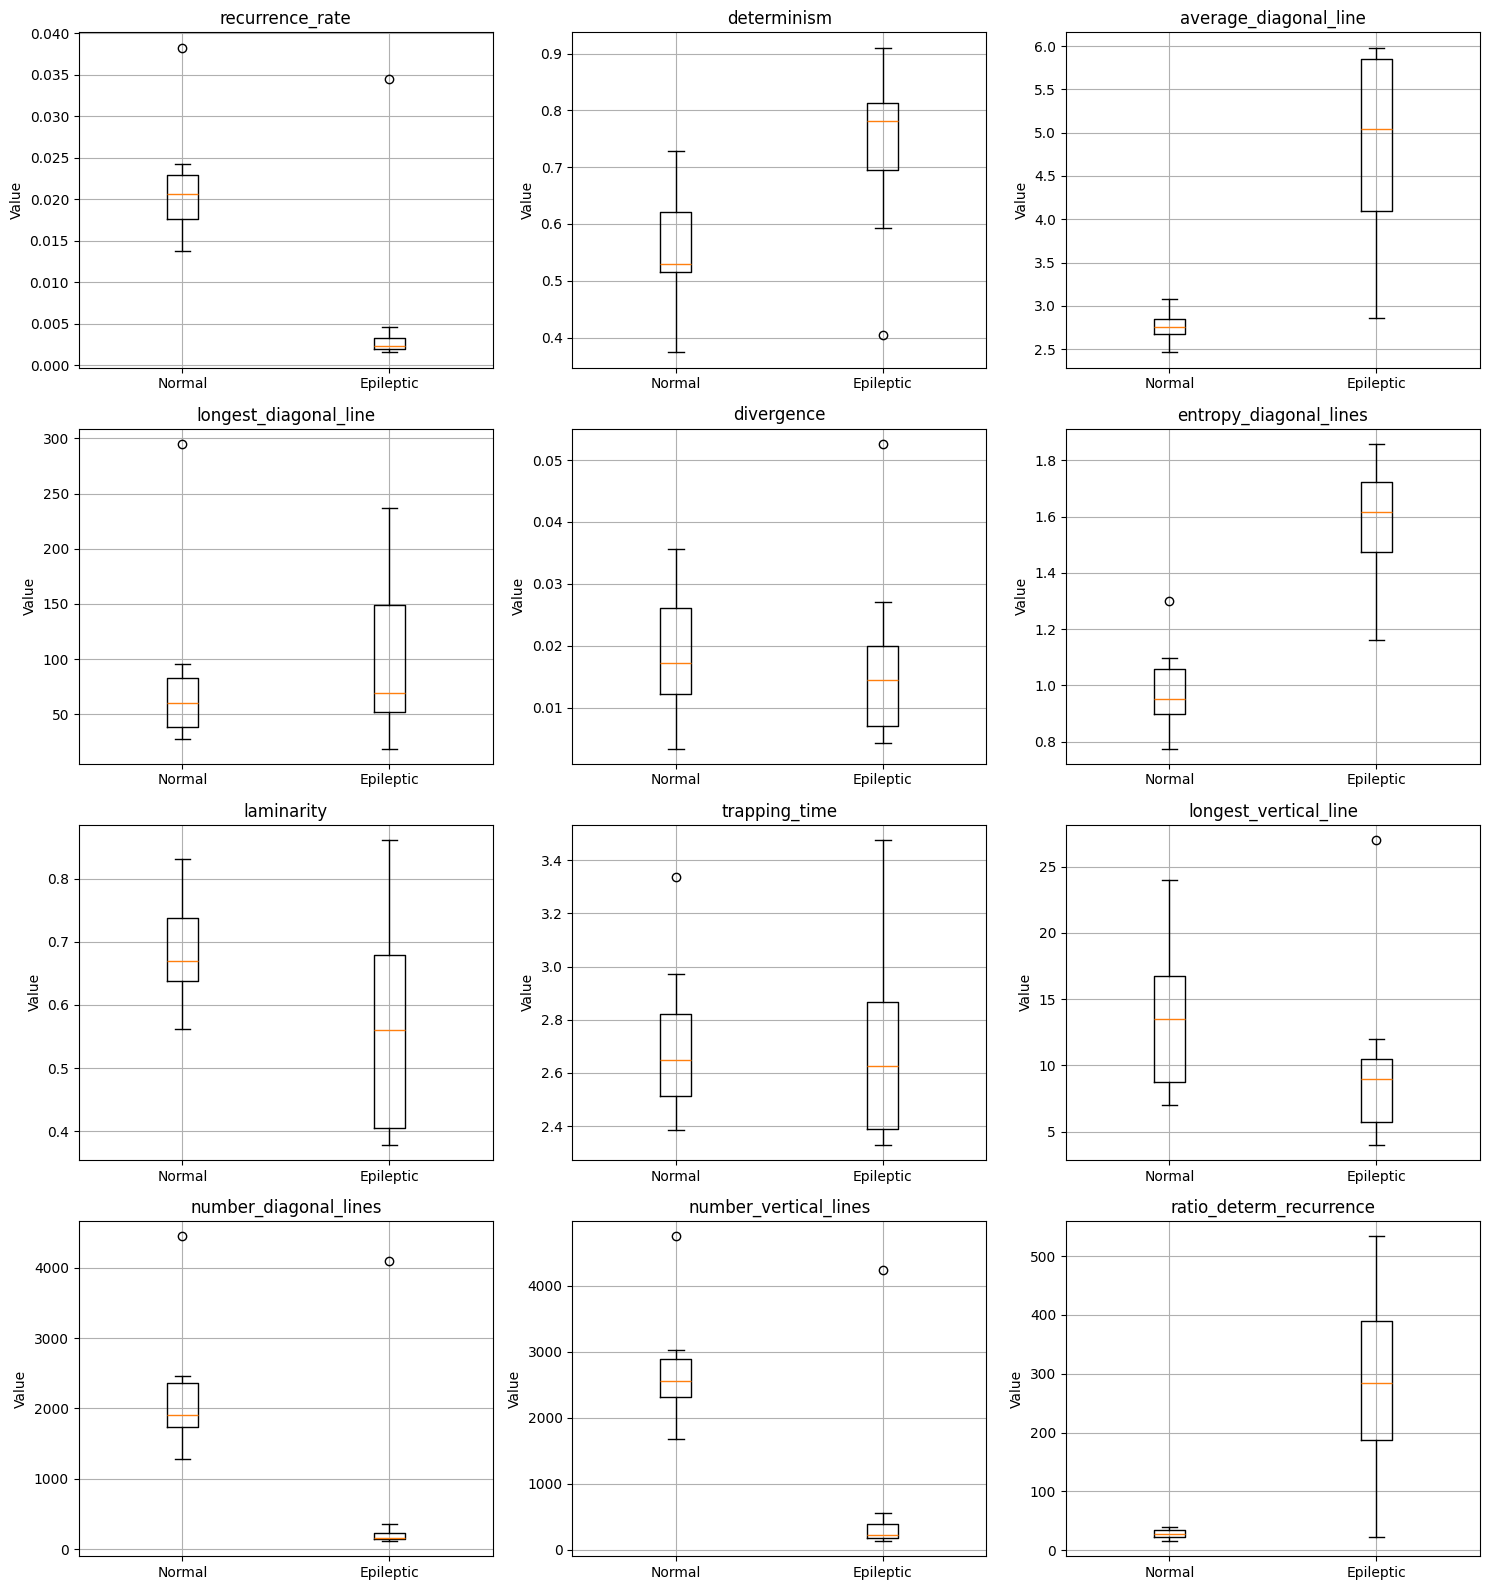

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



=== SVM Performance (5-fold CV) ===
Accuracy: Mean = 0.8667, Std = 0.1633
Precision: Mean = 0.9000, Std = 0.2000
Recall: Mean = 0.9333, Std = 0.1333
F1: Mean = 0.8933, Std = 0.1373
Roc_auc: Mean = nan, Std = nan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



=== Random Forest Performance (5-fold CV) ===
Accuracy: Mean = 0.8000, Std = 0.2667
Precision: Mean = 0.8000, Std = 0.4000
Recall: Mean = 0.7333, Std = 0.3887
F1: Mean = 0.7600, Std = 0.3878
Roc_auc: Mean = nan, Std = nan

=== Random Forest Feature Importances ===
entropy_diagonal_lines: 0.2333
average_diagonal_line: 0.1306
recurrence_rate: 0.1298
determinism: 0.1253
number_diagonal_lines: 0.1238
number_vertical_lines: 0.1117
ratio_determ_recurrence: 0.0625
longest_vertical_line: 0.0321
laminarity: 0.0228
trapping_time: 0.0210
longest_diagonal_line: 0.0058
divergence: 0.0013

=== Random Forest Confusion Matrix ===
[[8 0]
 [0 8]]


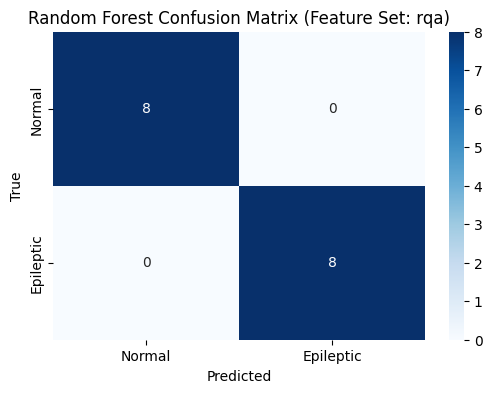

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from scipy.stats import entropy



# Constants
SEG_SIZE = 768
sfreq = 256  # Sampling frequency
radius = 0.04 # RQA radius from your original code

# Define index ranges
normal_idx_start = 10000
epileptic_idx_start = 122800
epileptic_idx_end = 129000

# Calculate number of segments
num_epileptic_segments = (epileptic_idx_end - epileptic_idx_start) // SEG_SIZE
num_normal_segments = num_epileptic_segments  # Match number of normal segments
normal_idx_end = normal_idx_start + num_normal_segments * SEG_SIZE

# Load single channel data
channel_data, times = load_single_channel(npy_path, metadata_path, selected_channel)
print(f"Loaded channel data with shape: {channel_data.shape}")
print(f"Loaded times with shape: {times.shape}")
print(f"Loaded metadata with keys: {metadata.keys()}")

# Define feature sets
phase_space_features = [
    "radius_mean", "radius_std",
    "excursions", "fast_return_rate",
    "convex_hull_vol"  # Excluding speed_spectral_ratio (all zeros)
]
rqa_features = [
    'recurrence_rate', 'determinism', 'average_diagonal_line',
    'longest_diagonal_line', 'divergence', 'entropy_diagonal_lines',
    'laminarity', 'trapping_time', 'longest_vertical_line',
    'number_diagonal_lines', 'number_vertical_lines', 'ratio_determ_recurrence'
]

# Select feature set: 'phase_space', 'rqa', or 'both'
feature_set = 'rqa'  # Change to 'phase_space' or 'rqa' to select specific features
if feature_set == 'phase_space':
    features = phase_space_features
elif feature_set == 'rqa':
    features = rqa_features
else:  # 'both'
    features = phase_space_features + rqa_features

# Initialize feature dictionaries
normal_features = {f: [] for f in features}
epileptic_features = {f: [] for f in features}

# Determine optimal embedding parameters using one normal segment
init_idx = normal_idx_start
segment_data = channel_data[init_idx:init_idx + SEG_SIZE]
max_tau_to_test = 50
optimal_tau, ami_curve = find_optimal_tau_ami(segment_data, max_tau=max_tau_to_test)
fnn_ratio, optimal_dim = false_nearest_neighbors(segment_data, tau=optimal_tau, max_dim=15, rtol=15.0, atol=2.0)
print(f"Optimal embedding dimension: {optimal_dim}")
print(f"Optimal tau: {optimal_tau}")

# Process segments and compute features
for i in range(num_normal_segments):
    # Normal segment
    normal_start = normal_idx_start + i * SEG_SIZE
    normal_segment = channel_data[normal_start:normal_start + SEG_SIZE]
    psv_normal = create_phase_space_vectors(normal_segment, m=4, tau=21)

    # Epileptic segment
    epileptic_start = epileptic_idx_start + i * SEG_SIZE
    if epileptic_start + SEG_SIZE <= epileptic_idx_end:
        epileptic_segment = channel_data[epileptic_start:epileptic_start + SEG_SIZE]
        psv_epileptic = create_phase_space_vectors(epileptic_segment, m=4, tau=21)

        # Compute phase space features for normal segment
        if feature_set in ['phase_space', 'both']:
            rf_norm = radius_features(psv_normal)
            ex_norm = excursion_count(psv_normal, pct=80)
            fr_norm = fast_return_rate(psv_normal, pct=80, max_return_samples=int(0.2 * sfreq))
            h_norm = convex_hull_volume(psv_normal[:, :3])
            normal_features["radius_mean"].append(rf_norm['radius_mean'])
            normal_features["radius_std"].append(rf_norm['radius_var'] ** 0.5)
            normal_features["excursions"].append(ex_norm['excursions'])
            normal_features["fast_return_rate"].append(fr_norm['fast_return_rate'])
            normal_features["convex_hull_vol"].append(h_norm['hull_volume'])

        # Compute phase space features for epileptic segment
        if feature_set in ['phase_space', 'both']:
            rf_epi = radius_features(psv_epileptic)
            ex_epi = excursion_count(psv_epileptic, pct=80)
            fr_epi = fast_return_rate(psv_epileptic, pct=80, max_return_samples=int(0.2 * sfreq))
            h_epi = convex_hull_volume(psv_epileptic[:, :3])
            epileptic_features["radius_mean"].append(rf_epi['radius_mean'])
            epileptic_features["radius_std"].append(rf_epi['radius_var'] ** 0.5)
            epileptic_features["excursions"].append(ex_epi['excursions'])
            epileptic_features["fast_return_rate"].append(fr_epi['fast_return_rate'])
            epileptic_features["convex_hull_vol"].append(h_epi['hull_volume'])

        # Compute RQA features for normal segment
        if feature_set in ['rqa', 'both']:
            rqa_metrics_norm, _ = calculate_rqa_metrics_custom(normal_segment, m=4, tau=21, radius=radius)
            for rqa_feature in rqa_features:
                normal_features[rqa_feature].append(rqa_metrics_norm[rqa_feature])

        # Compute RQA features for epileptic segment
        if feature_set in ['rqa', 'both']:
            rqa_metrics_epi, _ = calculate_rqa_metrics_custom(epileptic_segment, m=4, tau=21, radius=radius)
            for rqa_feature in rqa_features:
                epileptic_features[rqa_feature].append(rqa_metrics_epi[rqa_feature])

# Compute and print statistical summaries
print("\n=== Statistical Summaries for Features ===")
print(f"Number of segments: Normal = {len(normal_features['radius_mean' if feature_set in ['phase_space', 'both'] else rqa_features[0]])}, "
      f"Epileptic = {len(epileptic_features['radius_mean' if feature_set in ['phase_space', 'both'] else rqa_features[0]])}")
print("\n--- Normal Segments ---")
for feature in features:
    data = np.array(normal_features[feature])
    print(f"\n{feature}:")
    print(f"  Mean: {np.mean(data):.4f}")
    print(f"  Std: {np.std(data):.4f}")
    print(f"  Median: {np.median(data):.4f}")
    print(f"  Min: {np.min(data):.4f}")
    print(f"  Max: {np.max(data):.4f}")

print("\n--- Epileptic Segments ---")
for feature in features:
    data = np.array(epileptic_features[feature])
    print(f"\n{feature}:")
    print(f"  Mean: {np.mean(data):.4f}")
    print(f"  Std: {np.std(data):.4f}")
    print(f"  Median: {np.median(data):.4f}")
    print(f"  Min: {np.min(data):.4f}")
    print(f"  Max: {np.max(data):.4f}")

# Create boxplots for feature comparison
n_features = len(features)
n_rows = (n_features + 2) // 3  # Adjust rows for number of features
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    data = [normal_features[feature], epileptic_features[feature]]
    ax.boxplot(data, labels=['Normal', 'Epileptic'])
    ax.set_title(feature)
    ax.set_ylabel('Value')
    ax.grid(True)

# Hide unused subplots
for i in range(len(features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Prepare dataset for classification
X_normal = np.array([normal_features[f] for f in features]).T  # Shape: (8, n_features)
X_epileptic = np.array([epileptic_features[f] for f in features]).T  # Shape: (8, n_features)
X = np.vstack([X_normal, X_epileptic])  # Shape: (16, n_features)
y = np.array([0] * len(X_normal) + [1] * len(X_epileptic))  # Labels: 0 for normal, 1 for epileptic

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define classifiers
svm = SVC(kernel="linear", probability=True, random_state=42)
svm = SVC(kernel="rbf", probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# Evaluate SVM
svm_scores = cross_validate(svm, X_scaled, y, cv=cv, scoring=scoring, return_train_score=False)
print("\n=== SVM Performance (5-fold CV) ===")
for metric in scoring:
    mean_score = np.mean(svm_scores[f"test_{metric}"])
    std_score = np.std(svm_scores[f"test_{metric}"])
    print(f"{metric.capitalize()}: Mean = {mean_score:.4f}, Std = {std_score:.4f}")

# Evaluate Random Forest
rf_scores = cross_validate(rf, X_scaled, y, cv=cv, scoring=scoring, return_train_score=False)
print("\n=== Random Forest Performance (5-fold CV) ===")
for metric in scoring:
    mean_score = np.mean(rf_scores[f"test_{metric}"])
    std_score = np.std(rf_scores[f"test_{metric}"])
    print(f"{metric.capitalize()}: Mean = {mean_score:.4f}, Std = {std_score:.4f}")

# Train Random Forest on full data for feature importance and confusion matrix
rf.fit(X_scaled, y)
feature_importances = pd.Series(rf.feature_importances_, index=features)
print("\n=== Random Forest Feature Importances ===")
for feature, importance in feature_importances.sort_values(ascending=False).items():
    print(f"{feature}: {importance:.4f}")

# Confusion matrix for Random Forest
y_pred = rf.predict(X_scaled)
cm = confusion_matrix(y, y_pred)
print("\n=== Random Forest Confusion Matrix ===")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Epileptic"], yticklabels=["Normal", "Epileptic"])
plt.title(f"Random Forest Confusion Matrix (Feature Set: {feature_set})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()